## 1. Classes

In [1]:
from enum import Enum
from pydantic import BaseModel, Field
from typing import Optional, List
import torch
import torch.optim as optim
import torch.nn as nn
import pytorch_lightning as pl


class Optimizer(str, Enum):
    adadelta = "Adadelta"
    adagrad = "Adagrad"
    adam = "Adam"
    adamw = "AdamW"
    sparseadam = "SparseAdam"
    adamax = "Adamax"
    asgd = "ASGD"
    lbfgs = "LBFGS"
    rmsprop = "RMSprop"
    rprop = "Rprop"
    sgd = "SGD"


class Criterion(str, Enum):
    l1loss = "L1Loss"
    mseloss = "MSELoss"
    crossentropyloss = "CrossEntropyLoss"
    ctcloss = "CTCLoss"
    nllloss = "NLLLoss"
    poissonnllloss = "PoissonNLLLoss"
    gaussiannllloss = "GaussianNLLLoss"
    kldivloss = "KLDivLoss"
    bceloss = "BCELoss"
    bcewithlogitsloss = "BCEWithLogitsLoss"
    marginrankingloss = "MarginRankingLoss"
    hingeembeddingloss = "HingeEnbeddingLoss"
    multilabelmarginloss = "MultiLabelMarginLoss"
    huberloss = "HuberLoss"
    smoothl1loss = "SmoothL1Loss"
    softmarginloss = "SoftMarginLoss"
    multilabelsoftmarginloss = "MutiLabelSoftMarginLoss"
    cosineembeddingloss = "CosineEmbeddingLoss"
    multimarginloss = "MultiMarginLoss"
    tripletmarginloss = "TripletMarginLoss"
    tripletmarginwithdistanceloss = "TripletMarginWithDistanceLoss"


class TrainingParameters(BaseModel):
    target_size: tuple = Field(description='data target size')
    shuffle: bool = Field(description='shuffle data')
    batch_size: int = Field(description= 'batch size')
    val_pct: int = Field(description='validation percentage')
    latent_dim: int = Field(description='latent space dimension')
    base_channel_size: int = Field(description='number of base channels')  
    num_epochs: int = Field(description='number of epochs')
    optimizer: Optimizer
    criterion: Criterion
    learning_rate: float = Field(description='learning rate')
    seed: Optional[int] = Field(description='random seed')

        
class EvaluationParameters(TrainingParameters):
    latent_dim: List[int] = Field(description='list of latent space dimensions')

        
class TestingParameters(BaseModel):
    target_size: tuple = Field(description='data target size')
    batch_size: int = Field(description='batch size')
    seed: Optional[int] = Field(description='random seed')


class Encoder(nn.Module):
    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 width: int,
                 height: int,
                 latent_dim: int,
                 act_fn: object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - width, height: Dimensionality of the input image
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        linear_dim = int(width*height / 64)
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(2 * linear_dim * c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 width: int,
                 height: int,
                 latent_dim: int,
                 act_fn: object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - width, height: Dimensionality of the input image
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        self.width = width
        self.height = height
        c_hid = base_channel_size
        linear_dim = int(width*height / 64)
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2 * linear_dim * c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh()  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, int(self.width/8), int(self.height/8))
        x = self.net(x)
        return x


class Autoencoder(pl.LightningModule):
    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 num_input_channels: int = 3,
                 optimizer: object = Optimizer,
                 criterion: object = Criterion,
                 encoder_class: object = Encoder,
                 decoder_class: object = Decoder,
                 learning_rate: float = 1e-3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        self.optimizer = getattr(optim, optimizer.value)
        self.learning_rate = learning_rate
        if isinstance(criterion, Enum):
            criterion = getattr(nn, criterion.value)
            self.criterion = criterion()
        else:
            self.criterion = criterion
        self.train_loss = 0
        self.validation_loss = 0
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, width, height, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, width, height, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def predict_step(self, batch, batch_idx):
        """
        The forward function takes in an image and returns the reconstructed image
        during the prediction step
        """
        x, _ = batch  # We do not need the labels
        batch_hat = self.forward(x)
        return batch_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = self.criterion(x_hat, x)
#         loss = torch.nn.functional.mse_loss(x, x_hat, reduction="none")
#         loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate)
        return {"optimizer": optimizer}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss, on_epoch=True)
        self.train_loss += float(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss, on_epoch=True)
        self.validation_loss += float(loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss, on_epoch=True)

    def on_train_epoch_end(self):
        current_epoch = self.current_epoch
        num_batches = self.trainer.num_training_batches
        train_loss = self.train_loss
        validation_loss = self.validation_loss
        self.train_loss = 0
        self.validation_loss = 0
        print(current_epoch, ' ', train_loss / num_batches, ' ', validation_loss, flush=True)

    def on_validation_epoch_end(self):
        num_batches = self.trainer.num_val_batches[0] # may be a list[int]
        self.validation_loss = self.validation_loss/num_batches

    def on_train_end(self):
        print('Train process completed', flush=True)


## 2. Functions

In [140]:
import glob
import os

from PIL import Image
import numpy as np
import torch
from torchvision import datasets, transforms


def split_dataset(dataset, val_pct):
    '''
    This function splits the input dataset according to the splitting ratios
    Args:
        dataset:            Full dataset to be split
        val_pct:           Percentage for validation [0-100]
    Returns:
        train_set:          Training torch subset
        val_set:            Testing torch subset
    '''
    data_size = len(dataset)
    val_size = int(val_pct*data_size/100)
    train_set, val_set = torch.utils.data.random_split(dataset, [data_size - val_size, val_size])
    return train_set, val_set


def get_dataloaders(data_path, batch_size, num_workers, shuffle=False, target_size=None, 
                    data_keyword=None, val_pct=None):
    '''
    This function creates the dataloaders in PyTorch from directory or npy files
    Args:
        data_path:      [str] Path to data
        batch_size:     [int] Batch size
        num_workers:    [int] Number of workers
        shuffle:        [bool] Shuffle data
        target_size:    [tuple] Target size
        data_keyword:   [str] Keyword for data upload if npz file
        val_pct:        [int] Percentage for validation [0-100]
    Returns:
        PyTorch DataLoaders
    '''
    data_type = os.path.splitext(data_path)[-1]
    list_filenames = []
    if data_type == '.npz' or data_type == '.npy':
        if data_type == '.npz':
            with np.load(data_path, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII') as file:
                data = np.array(file[data_keyword])
        else:
            data = np.load(data_path)   # one single datafile
    else:
        data = []
        for dirpath, subdirs, files in os.walk(data_path):
            for file in files:
                if os.path.splitext(file)[-1] in ['.tiff', '.tif', '.jpg', '.jpeg', '.png']:
                    filename = os.path.join(dirpath, file)
                    img = Image.open(filename)
                    data.append(np.array(img))
                    list_filenames.append(filename)
        data = (np.array(data)/255).astype('float32')    # The dataset is normalized [0,1]
    if len(data.shape) == 3:
        data = np.expand_dims(data, 3)
    dataset = torch.tensor(data)
    dataset = dataset.transpose(1, 3)
    if target_size:
        dataset = torch.nn.functional.interpolate(dataset, target_size)
    (input_channels, width, height) = dataset.shape[1:]
    if val_pct:
        train_set, val_set = split_dataset(dataset, val_pct)
        train_loader = torch.utils.data.DataLoader(
            [[train_set[i], train_set[i]] for i in range(len(train_set))],
            shuffle=shuffle,
            batch_size=batch_size,
            num_workers=num_workers)
        if val_pct>0:
            val_loader = torch.utils.data.DataLoader(
                [[val_set[i], val_set[i]] for i in range(len(val_set))],
                shuffle=False,
                batch_size=batch_size,
                num_workers=num_workers)
            data_loader = [train_loader, val_loader]
        else:
            data_loader = [train_loader, None]
    else:
        data_loader = torch.utils.data.DataLoader(
            [[dataset[i], dataset[i]] for i in range(len(dataset))],
            shuffle=False,
            batch_size=batch_size,
            num_workers=num_workers)
        data_loader = [data_loader, None]
    return data_loader, (input_channels, width, height), list_filenames


def embed_imgs(model, data_loader):
    embed_list = []
    for counter, imgs in enumerate(data_loader):
        with torch.no_grad():
            z = model.encoder(imgs[0].to(model.device))
        embed_list.append(z)
    return torch.cat(embed_list, dim=0)


## 3. Training

In [141]:
import argparse
import json
import logging
import warnings

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch


warnings.filterwarnings('ignore')
SEED = 42
NUM_WORKERS = 0
INPUT_DIR = '/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz'
# INPUT_DIR = '/data/tanchavez/Datasets/born/train'
OUTPUT_DIR = 'classification_train2'
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING) # disable logs from pytorch lightning

train_parameters = TrainingParameters(
    target_size=(32,32),
    shuffle= True,
    batch_size=128,
    val_pct=20,
    latent_dim=32,
    base_channel_size=32,
    num_epochs= 100,
    optimizer='Adam',
    criterion='MSELoss',
    learning_rate=0.001,
    seed=3567841
)

if train_parameters.seed:
    seed = train_parameters.seed    # Setting the user-defined seed
else:
    seed = SEED                     # Setting the pre-defined seed
pl.seed_everything(seed)
print("Seed: "+str(seed))

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:"+str(device))

[train_loader, val_loader], (input_channels, width, height), tmp = get_dataloaders(
                                                                        INPUT_DIR,
                                                                        train_parameters.batch_size,
                                                                        NUM_WORKERS,
                                                                        train_parameters.shuffle,
                                                                        train_parameters.target_size,
                                                                        'x_train',
                                                                        train_parameters.val_pct)


trainer = pl.Trainer(default_root_dir=OUTPUT_DIR,
                     gpus=1 if str(device).startswith("cuda") else 0,
                     max_epochs=train_parameters.num_epochs,
                     progress_bar_refresh_rate=0,
                     callbacks=[ModelCheckpoint(dirpath = OUTPUT_DIR,
                                                save_last=True,
                                                filename='checkpoint_file',
                                                save_weights_only=False)])

model = Autoencoder(base_channel_size=train_parameters.base_channel_size,
                    latent_dim=train_parameters.latent_dim,
                    num_input_channels=input_channels,
                    optimizer=train_parameters.optimizer,
                    criterion=train_parameters.criterion,
                    learning_rate=train_parameters.learning_rate,
                    width=width,
                    height=height)

print('epoch train_loss val_loss')
trainer.fit(model, train_loader, val_loader)

Seed: 3567841
Device:cpu
epoch train_loss val_loss
0   25269.555514498872   25592.903073680645
Train process completed


### Train with a list of latent spaces

In [18]:
import argparse
import json
import sys
from IPython.utils import io
import logging
import warnings

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch


warnings.filterwarnings('ignore')
SEED = 42
NUM_WORKERS = 0
INPUT_DIR = '/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz'
# INPUT_DIR = '/data/tanchavez/Datasets/born/train'
OUTPUT_DIR = 'classification_train_swipe'
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING) # disable logs from pytorch lightning

eval_parameters = EvaluationParameters(
    target_size=(32,32),
    shuffle= True,
    batch_size= 32,
    val_pct=20,
    latent_dim=[16,32,44,55],
    base_channel_size= 32,
    num_epochs= 1,
    optimizer='Adam',
    criterion='MSELoss',
    learning_rate=0.001,
    seed=3567841
)

if eval_parameters.seed:
    seed = eval_parameters.seed    # Setting the user-defined seed
else:
    seed = SEED                     # Setting the pre-defined seed
pl.seed_everything(seed)
print("Seed: ", seed)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

[train_loader, val_loader], (input_channels, width, height), tmp = get_dataloaders(INPUT_DIR,
                                                                              eval_parameters.batch_size,
                                                                              NUM_WORKERS,
                                                                              eval_parameters.shuffle,
                                                                              eval_parameters.target_size,
                                                                              'x_train',
                                                                              eval_parameters.val_pct)

[test_loader, temp], (temp_channels, temp_w, temp_h), tmp = get_dataloaders(INPUT_DIR,
                                                                 eval_parameters.batch_size,
                                                                 NUM_WORKERS,
                                                                 False,
                                                                 eval_parameters.target_size,
                                                                 'x_test')
val_result = [{'test_loss': 0}]
for count, latent_dim in enumerate(eval_parameters.latent_dim):
    with io.capture_output() as captured: 
        trainer = pl.Trainer(default_root_dir=OUTPUT_DIR+f"/model_{latent_dim}",
                             gpus=1 if str(device).startswith("cuda") else 0,
                             max_epochs=eval_parameters.num_epochs,
                             progress_bar_refresh_rate=0,
                             weights_summary=None,
                             callbacks=[ModelCheckpoint(dirpath = OUTPUT_DIR+f"/model_{latent_dim}",
                                                        save_last=True,
                                                        filename='checkpoint_file',
                                                        save_weights_only=False)])
        model_ld = Autoencoder(base_channel_size=eval_parameters.base_channel_size,
                               latent_dim=latent_dim,
                               num_input_channels=input_channels,
                               optimizer=eval_parameters.optimizer,
                               criterion=eval_parameters.criterion,
                               learning_rate=eval_parameters.learning_rate,
                               width=width,
                               height=height)
        trainer.fit(model_ld, train_loader, val_loader)
        # Test best model on validation and test set
        test_result = trainer.test(model_ld, test_dataloaders=test_loader, verbose=False)
        if val_loader:
            val_result = trainer.test(model_ld, test_dataloaders=val_loader, verbose=False)
    if count == 0:
        print('latent_space_dim test validation')
    print(latent_dim, ' ', test_result[0]['test_loss'], ' ', val_result[0]['test_loss'])


Seed:  3567841
Device: cpu
latent_space_dim test validation
16   0.0004956357297487557   0.000529115553945303
32   0.0005953549989499152   0.0006113125127740204
44   0.0005008539301343262   0.0005353018641471863
55   0.0008389356662519276   0.0008574565872550011


## 4. Find similar images

In [81]:
import argparse
import json
import sys
from IPython.utils import io
import logging
import warnings

import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch


warnings.filterwarnings('ignore')
SEED = 42
NUM_WORKERS = 0
INPUT_DIR = '/data/tanchavez/Datasets/scattering/mixed_small_32x32.npz'
# INPUT_DIR = '/data/tanchavez/Datasets/born/train'
MODEL_DIR = 'classification_train2'
OUTPUT_DIR = 'classification_train2'
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING) # disable logs from pytorch lightning

test_parameters = TestingParameters(
    target_size = (32,32),
    batch_size = 32,
    seed = 3567841
)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

[test_loader, temp], (temp_channels, temp_w, temp_h), filenames = get_dataloaders(INPUT_DIR,
                                                                 test_parameters.batch_size,
                                                                 NUM_WORKERS,
                                                                 False,
                                                                 test_parameters.target_size,
                                                                 data_keyword='x_test')

model = Autoencoder.load_from_checkpoint(MODEL_DIR+'/last.ckpt')
trainer = pl.Trainer(progress_bar_refresh_rate=0)

test_img_embeds = embed_imgs(model, test_loader)        # test images in latent space

# Retrieve distance matrix
dist_matrix = np.zeros((test_img_embeds.shape[0],test_img_embeds.shape[0]))
for count, img_embed in enumerate(test_img_embeds):
    dist = torch.cdist(img_embed[None,], test_img_embeds, p=2)
    dist_matrix[count,:] = dist.squeeze(dim=0).detach().cpu().numpy()

dist_matrix = pd.DataFrame(dist_matrix)
if len(filenames)>0:
    dist_matrix['filename'] = filenames
dist_matrix.to_csv(OUTPUT_DIR+'/dist_matrix.csv',index=False)

# Reconstructed images
test_result = trainer.predict(model, dataloaders=test_loader)
test_result = torch.cat(test_result)
test_result = test_result.transpose(1, 3)
np.save(OUTPUT_DIR+'/reconstructed_images', test_result.cpu().detach().numpy())

Device: cpu


## 5. Retrive closest images (Dash)

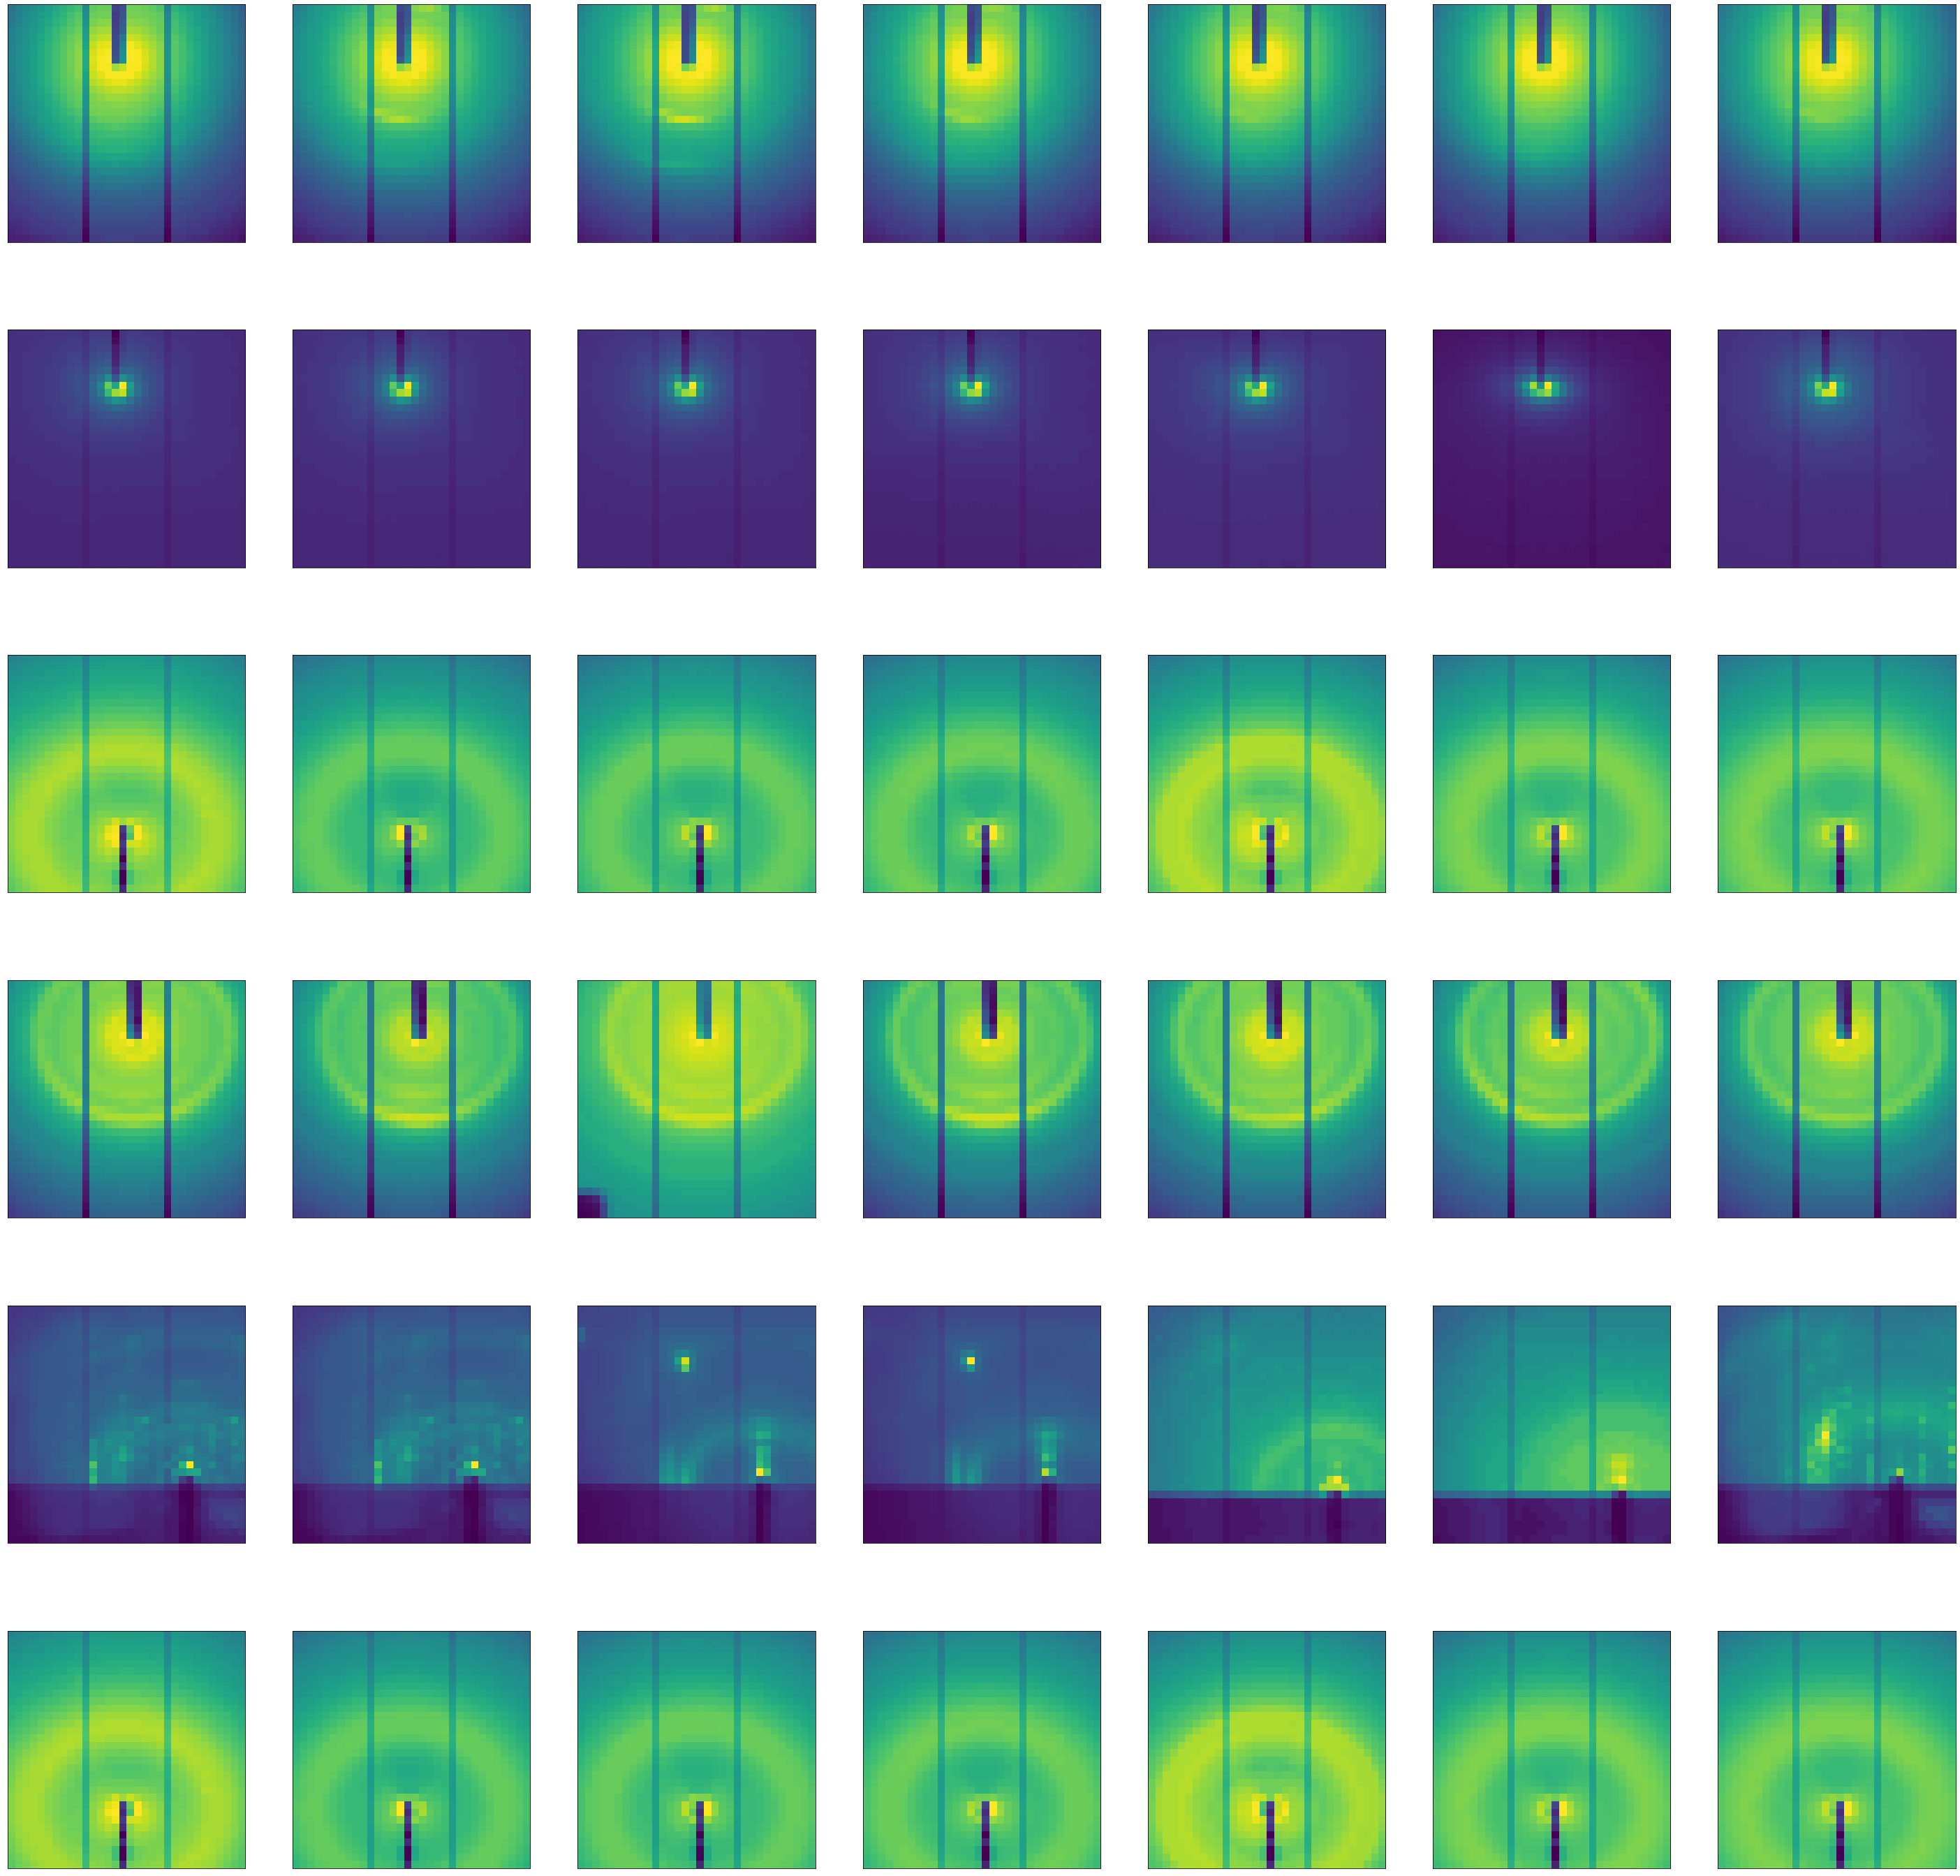

In [21]:
import numpy as np
import matplotlib.pyplot as plt

NUM_IMGS = 6
IMG_INDX = [100,1000,40,500,20,40]

path = '/Users/tanchavez/Documents/Dataset/X-Ray scattering/mixed_small_32x32.npz'   #read npz file with images
with np.load(path, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII') as data:
    test_data = data['x_test']

RESULTS_DIR = 'classification_train_localv1/dist_matrix.csv'

dist_matrix = np.loadtxt(RESULTS_DIR, delimiter=' ')

f, axarr = plt.subplots(len(IMG_INDX), NUM_IMGS+1, figsize=(50, 50))
for row, indx in enumerate(IMG_INDX):
    indices = np.argsort(dist_matrix[indx,:])
    similar_indx = indices[0:NUM_IMGS+1]
    similar_indx = similar_indx[similar_indx!=indx]
    full_indx = np.insert(similar_indx,0,indx)
    for col in range(NUM_IMGS+1):
        axarr[row,col].imshow(test_data[full_indx[col]])
        axarr[row,col].get_xaxis().set_visible(False)
        axarr[row,col].get_yaxis().set_visible(False)

plt.show()